# NLP Course 1

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from wordcloud import WordCloud
import re
import string
from collections import Counter, defaultdict

import spacy
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')

from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from imblearn.under_sampling import RandomUnderSampler

np.random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ryankingery/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset: Load and Preprocess Data

In [2]:
def get_text(text_file):
    df = pd.read_csv(text_file, encoding='ISO-8859-1')
    df = df[['v1', 'v2']]
    df.columns = ['labels', 'text_raw']
    df.labels = df.labels.replace('ham', 0)
    df.labels = df.labels.replace('spam', 1)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

text_file = Path('~/Repos/ml_tutorials/resources/spam.csv')
df = get_text(text_file)
df.head(10)

,labels,text_raw
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t..."
1,0,I sent my scores to sophas and i had to do sec...
2,1,We know someone who you know that fancies you....
3,0,Only if you promise your getting out as SOON a...
4,1,Congratulations ur awarded either å£500 of CD ...
5,0,"I'll text carlos and let you know, hang on"
6,0,K.i did't see you.:)k:)where are you now?
7,0,No message..no responce..what happend?
8,0,Get down in gandhipuram and walk to cross cut ...
9,0,You flippin your shit yet?


In [3]:
df.labels.value_counts()

0    4825
1     747
Name: labels, dtype: int64

In [4]:
def sub_special_tokens(text):
    # note I stole many of these regexes regularly from S.O.
    # convert simple URLs to xxurl token (e.g. www.google.com, http:google.com -> xxurl)
    text = re.sub(r' www.', ' http://www.', text)
    text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', ' xxurl ', text)
    # convert (British) phone numbers to xxphone token (e.g. 09058097218 -> xxphone)
    pat = r'\d{3}[-\.\s]??\d{4}[-\.\s]??\d{4}|\d{5}[-\.\s]??\d{3}[-\.\s]??\d{3}|(?:\d{4}\)?[\s-]?\d{3}[\s-]?\d{4})'
    text = re.sub(pat, ' xxphone ', text)
    # replace monetary values with xxmon token
    text = text.replace('£','$ ')
    text = re.sub(r'(\d+)[ ]{0,1}p', '$ 0.\1', text)
    text = re.sub(r'\$[ ]*(\d+[,\.])*\d+', ' xxmon ', text)
    # put xxup token before words in all caps (easy way to recognize info from capitalizing a word)
    text = re.sub(r'(\b[A-Z][A-Z0-9]*\b)', r' xxup \1 ', text)
    # put xxcap token before words with capitalized first letter (easy way to recognize first word in a sentence)
    text = re.sub(r'(\b[A-Z][a-z0-9]+\b)', r' xxcap \1 ', text)
    # convert some common text "emojis" to xxemoji: ;), :), :(, :-(, etc
    text = re.sub(r'[:;][ ]*[-]*[ ]*[()]', ' xxemoji ', text)
    return text

def normalize_text(text):
    # converts common patterns into special tokens
    text = sub_special_tokens(text)
    # convert text to lowercase
    text = text.lower()
    # strip out any lingering html tags
    text = re.sub(r'<[^>]*>', '', text)
    # convert all common abrevs to regular word
    text = text.replace('&',' and ')
    text = re.sub(r'\bu\b', ' you ', text)
    text = re.sub(r'\bur\b', ' your ', text)
    text = re.sub(r'\b2\b', ' to ', text)
    text = re.sub(r'\b4\b', ' for ', text)
    # put spaces between punctuation (eg: 9.Blah -> 9 . Blah)
    puncts = r'[' + re.escape(string.punctuation) + r']'
    text = re.sub('(?<! )(?=' + puncts + ')|(?<=' + puncts + ')(?! )', r' ', text)
    # strip non-ascii characters (easy way to denoise text a bit)
    text = text.encode("ascii", errors="ignore").decode()
    # remove all punctuation except ?
    text = re.sub(r"[^\w\s?]",' xxpunct ',text)
    # convert all other numbers to xxnum token (e.g. 123, 1.2.3, 1-2-3 -> xxnum)
    text = re.sub(r'\b([.-]*[0-9]+[.-]*)+\b', ' xxnum ', text)
    # remove nltk's common set of stop words (common for classical NLP analysis)
    stop_words = stopwords.words('english')
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # stem words using nltk snowball stemmer, e.g. converts {run, running, runs} all to "run"
    stemmer = SnowballStemmer('english')
    stemmed_text = ''
    for word in text.split():
            stemmed_text = stemmed_text + stemmer.stem(word) + ' '
    text = stemmed_text
    # sub the occurance of 2 or more spaces with a single space
    text = re.sub(r'[ ]{2,}',' ',text)
    return text

df['text'] = df['text_raw'].apply(normalize_text)
df.head(10)

,labels,text_raw,text
0,0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",xxcap funni fact xxcap nobodi teach volcano er...
1,0,I sent my scores to sophas and i had to do sec...,xxup sent score sopha secondari applic school ...
2,1,We know someone who you know that fancies you....,xxcap know someon know fanci xxpunct xxcap cal...
3,0,Only if you promise your getting out as SOON a...,xxcap promis get xxup soon xxpunct xxcap xxpun...
4,1,Congratulations ur awarded either å£500 of CD ...,xxcap congratul award either xxmon xxup cd gif...
5,0,"I'll text carlos and let you know, hang on",xxup xxpunct text carlo let know xxpunct hang
6,0,K.i did't see you.:)k:)where are you now?,xxup k xxpunct xxpunct see xxpunct xxemoji k x...
7,0,No message..no responce..what happend?,xxcap messag xxpunct xxpunct responc xxpunct x...
8,0,Get down in gandhipuram and walk to cross cut ...,xxcap get gandhipuram walk cross cut road xxpu...
9,0,You flippin your shit yet?,xxcap flippin shit yet ?


In [5]:
text = df['text'].tolist()
tokens = [[word for word in doc.split(' ') if len(word) > 0] for doc in text]
labels = df['labels'].tolist()

# Week 1: Logistic Regression

## Extract Features

In [5]:
pos_words = Counter(' '.join(df['text'][df.labels == 1]).split(' '))
neg_words = Counter(' '.join(df['text'][df.labels == 0]).split(' '))
len(pos_words), len(neg_words)

(1940, 5499)

In [7]:
pos_freqs = []
neg_freqs = []
for doc in text:
    pos_freqs.append(sum([pos_words[word] for word in doc.split(' ') if len(word) > 0]))
    neg_freqs.append(sum([neg_words[word] for word in doc.split(' ') if len(word) > 0]))

In [8]:
text[10], pos_freqs[10], neg_freqs[10]

('xxcap real tho suck xxpunct xxup xxpunct even cook whole electr xxpunct xxcap xxup xxpunct hungri xxpunct ',
 32073,
 106275)

In [9]:
X = [[1, pos_freqs[i], neg_freqs[i]] for i in range(len(text))]
X = np.array(X)
print(X[:2])

[[    1 18979 57964]
 [    1 24790 82537]]


In [34]:
y = np.array(labels)
X.shape, y.shape

((5572, 3), (5572,))

In [40]:
X_bal,y_bal = RandomUnderSampler().fit_sample(X, y)
X_train,X_test,y_train,y_test = train_test_split(X_bal, y_bal, test_size=0.2)
X_bal.shape, y_bal.shape

((1494, 3), (1494,))

## Training

In [36]:
model = LogisticRegression(fit_intercept=False, C=1.0)
model.fit(X_train_bal, y_train_bal)
y_pred = model.predict(X_test)

In [37]:
'accuracy:', accuracy_score(y_test, y_pred)

('accuracy:', 0.8795986622073578)

In [38]:
'F1:', f1_score(y_test, y_pred)

('F1:', 0.858267716535433)

In [39]:
'Random:', 1 - y_test.sum() / len(y_test)

('Random:', 0.5518394648829432)

In [41]:
model.coef_

array([[-2.25056914e+00,  6.81905884e-04, -1.92354627e-04]])

# Week 2: Naive Bayes

Naive: $w_j$ each independent. Naive <-> No Context.

$$x_i = (w_1, \cdots, w_m)$$
$$r_i = \frac{p(y_i=1|x_i)}{p(y_i=0|x_i)} = \frac{p(y_i=1)}{p(y_i=0)}\prod_{j=1}^m\frac{p(w_j|y_i=1)}{p(w_j|y_i=0)}$$
$$\hat y_i = \bigg(1 \text{ if } r_i\geq 1 \text{ else } 0\bigg) = \bigg(1 \text{ if } p(y_i=1|x_i) < p(y_i=0|x_i) \text{ else } 0 \bigg)$$

Fundamental assumptions of Naive Bayes:
- Features are independent. Probably not true in general for sentences, as context is important. But often works well.
- Test set has the same conditional distributions $p(w|y)$ as the training set.

In [6]:
tokens = [[word for word in doc.split(' ') if len(word) > 0] for doc in text]
word_counts = Counter(' '.join(text).split(' '))
word_counts.pop('')
word_counts.most_common(10)

[('xxpunct', 20352),
 ('xxcap', 11581),
 ('xxup', 6615),
 ('?', 1540),
 ('xxnum', 1314),
 ('xxmon', 691),
 ('call', 680),
 ('xxphone', 456),
 ('go', 453),
 ('get', 452)]

In [7]:
pos_words = Counter(' '.join(df['text'][df.labels == 1]).split(' '))
neg_words = Counter(' '.join(df['text'][df.labels == 0]).split(' '))
len(pos_words), len(neg_words)

(1940, 5499)

In [8]:
n_pos = sum(pos_words.values())
n_neg = sum(neg_words.values())
n_pos, n_neg

(23244, 73243)

In [9]:
# regular formula: pos_prob = pos_freq / n_pos
# with laplace smoothing: pos_prob = (pos_freq + 1) / (n_pos + n_unique)
n_unique = len(word_counts)
pos_probs = {word: (pos_words[word] + 1) / (n_pos + n_unique) for word in word_counts}
neg_probs = {word: (neg_words[word] + 1) / (n_neg + n_unique) for word in word_counts}

In [10]:
data = {'pos_probs': list(pos_probs.values()), 'neg_probs': list(neg_probs.values())}
vocab_df = pd.DataFrame(index=word_counts.keys(), data=data)
vocab_df['ratios'] = vocab_df['pos_probs'] / vocab_df['neg_probs']
vocab_df['log_ratios'] = np.log(vocab_df['ratios'])
vocab_df.head(20)

,pos_probs,neg_probs,ratios,log_ratios
xxcap,0.105532,0.105814,0.997333,-0.002671
funni,0.000034,0.000113,0.297704,-1.211654
fact,0.000067,0.000138,0.487153,-0.719177
nobodi,0.000034,0.000138,0.243576,-1.412325
teach,0.000034,0.000163,0.206103,-1.579379
volcano,0.000034,0.000025,1.339670,0.292423
erupt,0.000034,0.000025,1.339670,0.292423
xxpunct,0.144762,0.201123,0.719768,-0.328826
tsunami,0.000067,0.000038,1.786227,0.580106
aris,0.000034,0.000038,0.893113,-0.113042


In [11]:
ratios = []
for doc in tokens:
    # ratio = n_pos / n_neg * product(pos_probs / neg_probs for word in doc)
    rs = [pos_probs[word] / neg_probs[word] for word in doc]
    ratio = 1
    for r in rs:
        ratio *= r
    ratio *= n_pos / n_neg
    # handles numerical underflow better:
    # logratio = np.sum(np.log(rs))
    ratios.append(ratio)
ratios = np.array(ratios)
len(tokens), len(ratios)

(5572, 5572)

In [12]:
labels = np.array(df['labels']).astype(int)
ratios[labels == 0].shape

(4825,)

In [13]:
preds = (ratios >= 1).astype(int)
preds[:10]

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [14]:
'accuracy:', accuracy_score(labels, preds)

('accuracy:', 0.9890524048815507)

In [15]:
'F1:', f1_score(labels, preds)

('F1:', 0.960104643557881)

In [16]:
ratios.max(), df['text_raw'].iloc[np.argmax(ratios)], text[np.argmax(ratios)]

(9.849452337954807e+30,
 'Free entry to the gr8prizes wkly comp 4 a chance to win the latest Nokia 8800, PSP or å£250 cash every wk.TXT GREAT to 80878 http//www.gr8prizes.com 08715705022',
 'xxcap free entri gr xxmon xxpunct xxpunct rize wkli comp chanc win latest xxcap nokia xxnum xxpunct xxup psp xxmon cash everi wk xxpunct xxup txt xxup great xxnum http xxpunct xxpunct www xxpunct gr xxmon xxpunct xxpunct rize xxpunct com xxphone ')

In [17]:
ratios.min(), df['text_raw'].iloc[np.argmin(ratios)], text[np.argmin(ratios)]

(1.1104130324577605e-96,
 "How to Make a girl Happy? It's not at all difficult to make girls happy. U only need to be... 1. A friend 2. Companion 3. Lover 4. Chef . . .  &lt;#&gt; . Good listener  &lt;#&gt; . Organizer  &lt;#&gt; . Good boyfriend  &lt;#&gt; . Very clean  &lt;#&gt; . Sympathetic  &lt;#&gt; . Athletic  &lt;#&gt; . Warm . . .  &lt;#&gt; . Courageous  &lt;#&gt; . Determined  &lt;#&gt; . True  &lt;#&gt; . Dependable  &lt;#&gt; . Intelligent . . .  &lt;#&gt; . Psychologist  &lt;#&gt; . Pest exterminator  &lt;#&gt; . Psychiatrist  &lt;#&gt; . Healer . .  &lt;#&gt; . Stylist  &lt;#&gt; . Driver . . Aaniye pudunga venaam..",
 'xxcap xxcap make girl xxcap happi ? xxcap xxpunct difficult make girl happi xxpunct xxup need xxpunct xxpunct xxpunct xxnum xxpunct xxup friend xxpunct xxcap companion xxnum xxpunct xxcap lover xxpunct xxcap chef xxpunct xxpunct xxpunct lt xxpunct xxpunct gt xxpunct xxpunct xxcap good listen lt xxpunct xxpunct gt xxpunct xxpunct xxcap organ lt xxpunct xxp

(array([1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 4.000e+00, 2.600e+01,
        1.072e+03, 3.810e+03, 4.210e+02, 2.360e+02]),
 array([-220.94343688, -191.71259633, -162.48175578, -133.25091522,
        -104.02007467,  -74.78923412,  -45.55839357,  -16.32755301,
          12.90328754,   42.13412809,   71.36496864]),
 <a list of 10 Patch objects>)

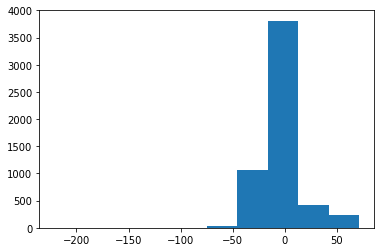

In [18]:
plt.hist(np.log(ratios))

# Week 3: Word Embeddings

## Coocurrance Matrix

In [6]:
vocab = set(' '.join(text).split(' '))
vocab.remove('')
itos = list(vocab)
stoi = {itos[idx]:idx for idx in range(len(itos))}

### Word-By-Word
Count number of times word pairs co-occur within a given window of size $k$. Get a matrix of size $V \times V$.

In [7]:
k = 2
coocurances = np.zeros((len(vocab), len(vocab)))
# O(N*T^2)
for doc in tokens:
    for idx in range(len(doc)):
        word_1 = doc[idx]
        for word_2 in doc[max(0,idx - k): idx + k + 1]:
            i,j = (stoi[word_1], stoi[word_2])
            coocurances[i,j] += 1
coocurances = pd.DataFrame(index=itos, columns=itos, data=coocurances).astype(int)
coocurances.head(5)

,especi,lover,test,rcd,beehoon,sis,inperialmus,hogolo,korean,excel,...,cro1327,adi,warranti,belt,yetti,wan2,argument,bat,bangbab,bonus
especi,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lover,0,11,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
test,0,0,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rcd,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
beehoon,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
coocurances.loc['xxpunct'].sort_values(ascending=False).head(20)

xxpunct    40478
xxcap       8628
xxup        4493
xxmon       1214
xxnum       1209
gt           957
lt           715
call         514
?            400
xxphone      306
love         304
ok           303
get          293
go           287
day          228
good         221
xxemoji      212
lor          210
know         210
k            188
Name: xxpunct, dtype: int64

### Word-By-Document

Count number of times a word occurs within a certain topic. Get a matrix of size $V \times T$.

In [9]:
topics = sorted(np.unique(labels))
n_topics = len(topics)
wordbydoc = np.zeros((len(vocab), n_topics))
for i in range(n_topics):
    samples = df['text'][df.labels == i].tolist()
    corpus = ' '.join(samples).split(' ')
    corpus.remove('')
    counter = Counter(corpus)
    wordbydoc[:, i] = [counter[word] for word in itos]
wordbydoc = pd.DataFrame(index=itos, columns=topics, data=wordbydoc).astype(int)
wordbydoc.sort_values(by=[0], axis=0, ascending=False).head(20)

,0,1
xxpunct,16043,4309
xxcap,8440,3141
xxup,4504,2111
?,1367,173
go,418,35
xxemoji,407,0
xxnum,390,924
get,362,90
gt,318,0
lt,316,0


### Distance and PCA

In [10]:
dist_euc = lambda x,y: np.linalg.norm(x - y)
x = wordbydoc[0]
y = wordbydoc[1]
print('dist_euc(spam, notspam):', dist_euc(x, y))

dist_euc(spam, notspam): 13278.495584967448


In [11]:
dist_cos = lambda x,y: 1 - np.dot(x, y) / (np.dot(x, x) * np.dot(y, y))**(1/2)
x = wordbydoc[0]
y = wordbydoc[1]
print('dist_cos(spam, notspam):', dist_cos(x, y))

dist_cos(spam, notspam): 0.044373491276475274


In [14]:
def pca(X, k=2):
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    C = 1/len(X) * X.T @ X
#     U,S,Vt = np.linalg.svd(C)
#     Z = X @ U[:, :k]
#     print(f'% variance explained: {np.diag(S)[:k].sum() / np.diag(S).sum()}')
    # C = scipy.sparse.csc_matrix(C)
    svd = TruncatedSVD(n_components=k)
    Z = svd.fit_transform(C)
    print(f'% variance explained: {svd.explained_variance_ratio_.sum()}')
    return Z

Z = pca(coocurances)
Z.shape

% variance explained: 0.8663614048770966


(6529, 2)

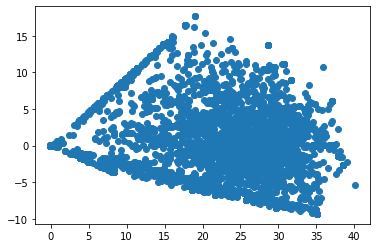

In [16]:
plt.scatter(Z[:, 0], Z[:, 1])

# Week 4: Vector Spaces

$$ \nabla^2 u - \frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} = 0$$

Translation: To translate $X$ to $Y$, find params $R$ st $XR \approx Y$ by minimizing $L=||XR-Y||_F^2$ (via gradient descent). Note $||A||_F^2=\text{tr} (A^T A)$, $\nabla_R L = 2 X^T (XR-Y)$. In practice, minimize $J = \frac{1}{n} L$.

In [6]:
def hash_table(array, n_buckets):
    hash = lambda x: x % n_buckets
    table = {i:[] for i in range(n_buckets)}
    for x in array:
        h = hash(x)
        table[h].append(x)
    return table

array = np.random.randint(0, 100+1, size=10)
table = hash_table(array, n_buckets=10)
table

{0: [],
 1: [41],
 2: [],
 3: [53, 83],
 4: [24],
 5: [95],
 6: [],
 7: [37, 27],
 8: [],
 9: [29, 9, 59]}

$$\text{hash}(x) = \sum_{i=0}^{n-1} 2^i h_i(x) = h_0(x) + 2h_1(x) + \cdots + 2^{n-1}h_{n-1}(x),$$
$$h_i(x)=\text{sgn}(n_i \cdot x)$$

In [7]:
def hash_planes(normals, x):
    side_of_plane = lambda n, x: int(np.dot(n, x) > 0)
    signs = [2**i * side_of_plane(normals[i], x) for i in range(len(normals))]
    return sum(signs)

In [8]:
X = np.random.uniform(low=-1, high=1, size=(10,3))
normals = np.array([[0, 0, 1], [0, 1, 0], [1, 0, 0]])
labels = [hash_planes(normals, x) for x in X]
list(zip(labels, X))

[(3, array([-0.53333435,  0.25066034,  0.49415653])),
 (0, array([-0.56257222, -0.8801134 , -0.73805251])),
 (6, array([ 0.21199393,  0.69889281, -0.91000636])),
 (4, array([ 0.46830252, -0.31736271, -0.04294326])),
 (4, array([ 0.8577191 , -0.33605699, -0.06932613])),
 (0, array([-0.97263517, -0.83680256, -0.48281682])),
 (2, array([-0.94429552,  0.26275065, -0.14720329])),
 (4, array([ 0.09629041, -0.65070563, -0.40813594])),
 (6, array([ 0.32764895,  0.93060545, -0.89916645])),
 (7, array([0.78076864, 0.1537624 , 0.12783913]))]

In [9]:
n_dims = 2
n_planes = 3

rand_planes = np.random.normal(size=(n_planes,n_dims))

In [15]:
v = np.array([2,2])
side_of_plane = lambda n, x: int(np.dot(n, x) > 0)
sides = [side_of_plane(plane, v) for plane in rand_planes]
label = hash_planes(rand_planes, v)
sides, label

([0, 0, 1], 4)

In [17]:
word_embeddings = {
    'I': np.array([1,0,1]),
    'love': np.array([-1,0,1]),
    'learning': np.array([1,0,1])
}

doc = 'I love learning'.split(' ')

doc_embedding = np.array([word_embeddings[word] for word in doc]).sum(axis=0)
    
print(doc_embedding)

[1 0 3]
